In [1]:
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import riemann
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['lines.markeredgewidth'] = 0.5
matplotlib.rcParams['lines.markersize'] = 8
import time

This jupyter notebook contains functions, programs and plots for **APC 523 Lecture 23 on Advanced Hyperbolic Solvers** (copyright Romain Teyssier, Princeton University). 


In [2]:
gamma = 1.4

In [3]:
def prim_to_cons(w):
    u = 0.*w
    # density
    u[0] = w[0]
    # momentum
    u[1] = w[0]*w[1]
    # total energy
    u[2] = 0.5*w[0]*w[1]**2 + w[2]/(gamma-1)
    return u

In [4]:
def prim_to_flux(w):
    f = 0.*w
    # mass flux
    f[0] = w[0]*w[1]
    # momentum flux
    f[1] = w[0]*w[1]**2+w[2]
    # total energy flux
    f[2] = (0.5*w[0]*w[1]**2 + gamma*w[2]/(gamma-1))*w[1]
    return f

In [5]:
def cons_to_prim(u):
    w = 0.*u
    # density
    w[0] = u[0]
    # velocity
    w[1] = u[1]/u[0]
    # pressure
    w[2] = (gamma-1)*(u[2]-0.5*w[0]*w[1]**2)
    return w

In [27]:
def set_ic(x, ic_type = "sod test"):
    n = x.size
    d = np.zeros(n)
    v = np.zeros(n)
    p = np.zeros(n)
    if ic_type == "sod test":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif ic_type == "toro test1":
        for i in range(0,n):
            if (x[i] < 0.3):
                d[i] = 1
                v[i] = 0.75
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif ic_type == "toro test2":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = -2
                p[i] = 0.4
            else:
                d[i] = 1
                v[i] = 2
                p[i] = 0.4
    elif ic_type == "toro test6":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 5.99924
                v[i] = 19.5975
                p[i] = 46.0950
            else:
                d[i] = 31.0799559
                v[i] = 4.71607927
                p[i] = 1692.45760109
    elif ic_type == "toro test3":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1000
            else:
                d[i] = 1
                v[i] = 0
                p[i] = 0.01
    elif ic_type == "shu osher":
        for i in range(0,n):
            if (x[i] < 0.125):
                d[i] = 3.857143
                v[i] = 2.629369
                p[i] = 10.33333
            else:
                d[i] = 1+0.2*np.sin(2*np.pi*8*x[i])
                v[i] = 0
                p[i] = 1
    elif ic_type == "supersonic blob":
        for i in range(0,n):
            if (x[i] > 0.4 and x[i] < 0.6):
                d[i] = 10
                v[i] = 3*np.sqrt(50/3)
                p[i] = 1
            else:
                d[i] = 0.1
                v[i] = 0
                p[i] = 1

    else:
        print("Unkown IC type=",ic_type)
    # convert to conservative variables
    w = np.reshape([d,v,p],(3,n))
    u = prim_to_cons(w)
    return u

In [7]:
def set_bc(u, type = "periodic"):
    if type == "periodic":
        u[:,0] = u[:,-8]
        u[:,1] = u[:,-7]
        u[:,2] = u[:,-6]
        u[:,3] = u[:,-5]
        u[:,-1] = u[:,7]
        u[:,-2] = u[:,6]
        u[:,-3] = u[:,5]
        u[:,-4] = u[:,4]
    elif type == "free":
        u[:,0] = u[:,4]
        u[:,1] = u[:,4]
        u[:,2] = u[:,4]
        u[:,3] = u[:,4]
        u[:,-1] = u[:,-5]
        u[:,-2] = u[:,-5]
        u[:,-3] = u[:,-5]
        u[:,-4] = u[:,-5]
    else:
        print("Unknow BC type")

In [8]:
def smooth_extrema(u,bc_type):
    
    # compute central first derivative
    du = 0.5*(u[:,2:]-u[:,:-2])
    uprime = np.pad(du,[(0,0),(1,1)])
    set_bc(uprime,bc_type)
    
    # compute left, right and central second derivative
    dlft = uprime[:,1:-1]-uprime[:,:-2]
    drgt = uprime[:,2:]-uprime[:,1:-1]
    dmid = 0.5*(dlft+drgt)
    
    # detect discontinuity on the left (alpha_left<1)
    with np.errstate(divide='ignore', invalid='ignore'):
        alfp = np.minimum(1,np.maximum(2*dlft,0)/dmid)
        alfm = np.minimum(1,np.minimum(2*dlft,0)/dmid)
    alfl = np.where(dmid>0,alfp,alfm)
    alfl = np.where(dmid==0,1,alfl)
    
    # detect discontinuity on the right (alpha_right<1)
    with np.errstate(divide='ignore', invalid='ignore'):
        alfp = np.minimum(1,np.maximum(2*drgt,0)/dmid)
        alfm = np.minimum(1,np.minimum(2*drgt,0)/dmid)
    alfr = np.where(dmid>0,alfp,alfm)
    alfr = np.where(dmid==0,1,alfr)
    
    # finalize smooth extrema marker (alpha=1)
    alf = np.minimum(alfl,alfr)
    alpha = np.pad(alf,[(0,0),(1,1)])
    set_bc(alpha,bc_type)
        
    return alpha

In [9]:
def trace(u, alpha, space = 1):
    
    if (space == 1):
        uleft = u[:,3:-3]
        uright = u[:,3:-3]
        
    if (space == 2):
        uleft = (-u[:,2:-4]+4*u[:,3:-3]+u[:,4:-2])/4
        uright = (u[:,2:-4]+4*u[:,3:-3]-u[:,4:-2])/4
                
    if (space == 3):
        uleft = (-u[:,2:-4]+5*u[:,3:-3]+2*u[:,4:-2])/6
        uright = (2*u[:,2:-4]+5*u[:,3:-3]-u[:,4:-2])/6
        umiddle = (-u[:,2:-4]+26*u[:,3:-3]-u[:,4:-2])/24
        
    if (space == 4):
        uleft = (u[:,1:-5]-6*u[:,2:-4]+20*u[:,3:-3]+10*u[:,4:-2]-u[:,5:-1])/24
        uright = (-u[:,1:-5]+10*u[:,2:-4]+20*u[:,3:-3]-6*u[:,4:-2]+u[:,5:-1])/24
        umiddle = (-u[:,2:-4]+26*u[:,3:-3]-u[:,4:-2])/24

    if (space == 5):
        uleft = (2*u[:,1:-5]-13*u[:,2:-4]+47*u[:,3:-3]+27*u[:,4:-2]-3*u[:,5:-1])/60
        uright = (-3*u[:,1:-5]+27*u[:,2:-4]+47*u[:,3:-3]-13*u[:,4:-2]+2*u[:,5:-1])/60
        umiddle = (27*u[:,1:-5]-348*u[:,2:-4]+6402*u[:,3:-3]-348*u[:,4:-2]+27*u[:,5:-1])/5760

    if (space >1):

        bigm = np.maximum(u[:,2:-4],np.maximum(u[:,3:-3],u[:,4:-2]))
        smallm = np.minimum(u[:,2:-4],np.minimum(u[:,3:-3],u[:,4:-2]))
        
        if (space>2):
            bigmj = np.maximum(umiddle,np.maximum(uleft,uright))-u[:,3:-3]
            smallmj = np.minimum(umiddle,np.minimum(uleft,uright))-u[:,3:-3]
        else:
            bigmj = np.maximum(uleft,uright)-u[:,3:-3]
            smallmj = np.minimum(uleft,uright)-u[:,3:-3]

        # compute limiter
        theta = np.minimum(1,np.minimum(abs(bigm-u[:,3:-3])/(abs(bigmj)+1e-15),abs(smallm-u[:,3:-3])/(abs(smallmj)+1e-15)))
        # apply smooth extrema detection
        aslp = np.minimum(np.minimum(alpha[:,2:-4],alpha[:,4:-2]),alpha[:,3:-3])
        theta = np.where(aslp<1,theta,1)
        # apply limiter
        uleft = theta*(uleft-u[:,3:-3])+u[:,3:-3]
        uright = theta*(uright-u[:,3:-3])+u[:,3:-3]
    
    return uleft, uright

In [10]:
def cmp_flux(u, bc_type = "periodic", riemann_solver="llf", space = 1):
    
    set_bc(u,bc_type)        # set boundary conditions
        
    w = cons_to_prim(u)         # convert to primitive variables

    cs = np.sqrt(gamma*w[2]/w[0])  # compute sound speed
        
    alpha = smooth_extrema(w, bc_type)  # compute smooth extrema detector
 
    wminus, wplus = trace(w, alpha, space = space)  # computed interface values

    # solve riemann problem

    wleft = wminus[:,:-1]    # left state for riemann problem
    wright = wplus[:,1:]    # right state for riemann problem

    if(riemann_solver == 'llf'):
        flux = riemann.llf(wleft,wright)

    if(riemann_solver == 'hll'):
        flux = riemann.hll(wleft,wright)

    if(riemann_solver == 'hllc'):
        flux = riemann.hllc(wleft,wright)

    if(riemann_solver == 'exact'):
        flux = riemann.exact(wleft,wright)

    return flux, w, cs

In [11]:
def weno(tend=1,n=100,cfl=0.8,ic_type="sod test",bc_type="periodic",riemann_solver="llf",time=1,space=1):

    # set run parameters
    h = 1/n
    nitermax = 100000
    print("cell=", n, " itermax=", nitermax)

    # set grid geometry
    xf = np.linspace(0,1,n+1)
    x = 0.5*(xf[1:]+xf[:-1])
    
    # allocate permanent storage
    u = np.zeros([nitermax+1,3,n])

    # set initial conditions
    u[0] = set_ic(x,ic_type=ic_type)
    
    # allocate temporary workspace
    u1 = np.zeros([3,n+8])
    u2 = np.zeros([3,n+8])
    u3 = np.zeros([3,n+8])
    u4 = np.zeros([3,n+8])
    
    # init time and iteration counter
    t = 0
    niter = 1

    # main time loop
    while(t<tend and niter <= nitermax):
        
        u1[:,4:-4] = u[niter-1]     # copy old solution
        
        flux, w, cs = cmp_flux(u1, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
        k1 = -(flux[:,1:]-flux[:,:-1])/h
        dt = cfl * h/max(abs(w[1])+cs) # compute new time step

        if(time == 1): # forward Euler
            
             unew = u1[:,4:-4] + k1 * dt
            
        if(time == 2): # RK2 or SSP RK2
            
            u2[:,4:-4] = u1[:,4:-4] + k1 * dt / 2
#            u2[:,4:-4] = u1[:,4:-4] + k1 * dt # SSP
            flux, w, cs = cmp_flux(u2, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k2 = -(flux[:,1:]-flux[:,:-1])/h
            unew = u1[:,4:-4] + k2 * dt
#            unew = u1[:,4:-4]/2 + (u2[:,4:-4] + k2 * dt)/2 # SSP
     
        if(time == 3): # RK3 or SSP RK3
            
            u2[:,4:-4] = u1[:,4:-4] + k1 * dt/3
#            u2[:,4:-4] = u1[:,4:-4] + k1 * dt # SSP
            flux, w, cs = cmp_flux(u2, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k2 = -(flux[:,1:]-flux[:,:-1])/h
            u3[:,4:-4] = u1[:,4:-4] + k2 * 2*dt/3
#            u3[:,4:-4] = 3/4*u1[:,4:-4] + 1/4*(u2:,[4:-4]+k2 * dt) # SSP
            flux, w, cs = cmp_flux(u3, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k3 = -(flux[:,1:]-flux[:,:-1])/h
            unew = u1[:,4:-4] + (k1 + 3*k3) * dt/4
#            unew = 1/3*u1[:,4:-4] + 2/3*(u3[:,4:-4]+k3 * dt)  SSP
        
        if(time == 4): # RK4
            
            u2[:,4:-4] = u1[:,4:-4] + k1 * dt/2
            flux, w, cs = cmp_flux(u2, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k2 = -(flux[:,1:]-flux[:,:-1])/h
            u3[:,4:-4] = u1[:,4:-4] + k2 * dt/2
            flux, w, cs = cmp_flux(u3, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k3 = -(flux[:,1:]-flux[:,:-1])/h
            u4[:,4:-4] = u1[:,4:-4] + k3 * dt
            flux, w, cs = cmp_flux(u4, bc_type = bc_type, riemann_solver = riemann_solver, space = space)
            k4 = -(flux[:,1:]-flux[:,:-1])/h
            unew = u1[:,4:-4] + (k1 + 2*k2 + 2*k3 + k4) * dt/6

        u[niter] = unew         # store new solution
        t = t+dt             # update time
#        print(niter,t,dt)
        niter = niter+1     # update iteration counter

    print("Done ",niter-1,t)
    return u[0:niter]

In [12]:
u1=weno(tend=0.245,n=100,cfl=0.8,ic_type="sod test",bc_type="free",riemann_solver="hllc",time=1,space=1)
u2=weno(tend=0.245,n=100,cfl=0.8,ic_type="sod test",bc_type="free",riemann_solver="hllc",time=2,space=2)
u3=weno(tend=0.245,n=100,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="hllc",time=3,space=3)
u4=weno(tend=0.245,n=100,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="hllc",time=3,space=4)

cell= 100  itermax= 100000
Done  66 0.24654766500279954
cell= 100  itermax= 100000
Done  67 0.24683752245554247
cell= 100  itermax= 100000
Done  134 0.24584235292130227
cell= 100  itermax= 100000
Done  134 0.2464929902548667


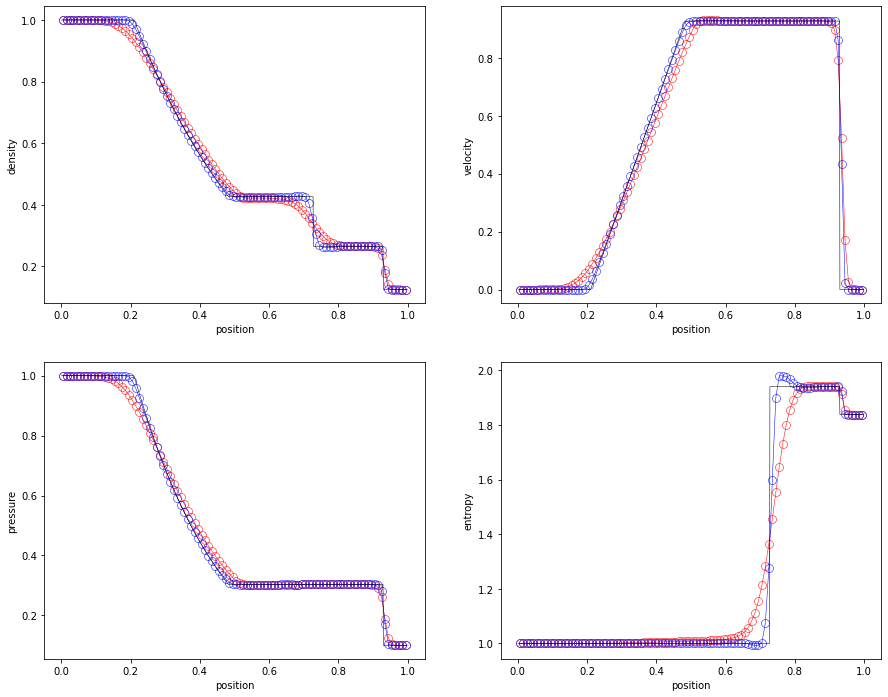

In [13]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u4[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.245
    d,v,p = riemann.exact_solution(s,[1,0,1],[0.125,0,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(x1,w2[0,:],"bo-",mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(x1,w2[1,:],"bo-",mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(x1,w2[2,:],"bo-",mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,"bo-",mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")

plt.savefig('sod_test_high_order.png')

In [14]:
u1=weno(tend=0.2,n=100,cfl=0.8,ic_type="toro test1",bc_type="free",riemann_solver="hllc",time=1,space=1)
u2=weno(tend=0.2,n=100,cfl=0.4,ic_type="toro test1",bc_type="free",riemann_solver="hllc",time=3,space=4)

cell= 100  itermax= 100000
Done  67 0.20027533976989706
cell= 100  itermax= 100000
Done  137 0.2010336093315614


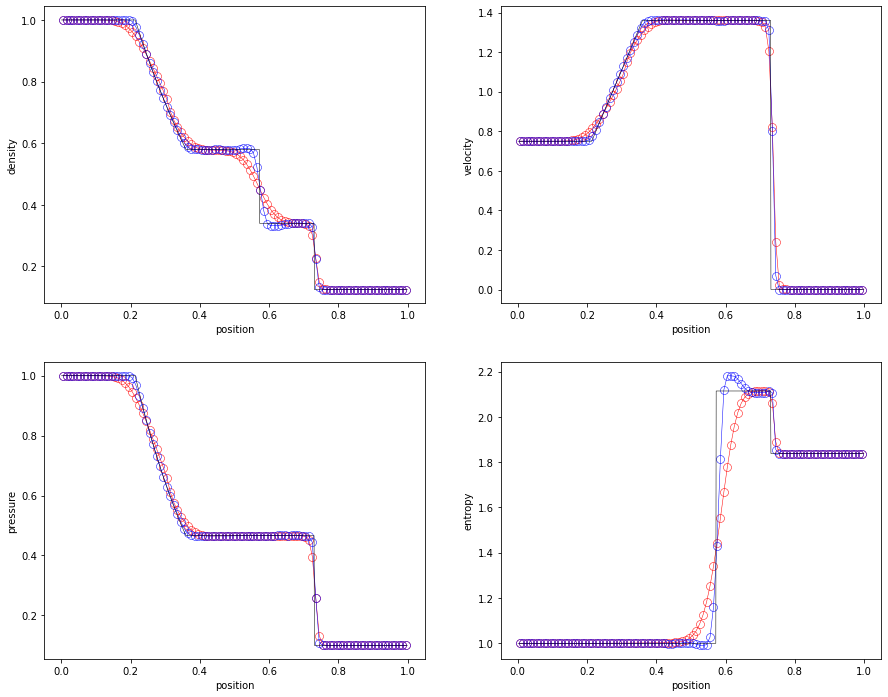

In [15]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.3)/0.2
    d,v,p = riemann.exact_solution(s,[1,0.75,1],[0.125,0,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(x1,w2[0,:],"bo-",mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(x1,w2[1,:],"bo-",mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(x1,w2[2,:],"bo-",mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,"bo-",mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")

plt.savefig('toro_test1_high_order.png')

In [16]:
u1=weno(tend=0.15,n=100,cfl=0.8,ic_type="toro test2",bc_type="free",riemann_solver="hllc",time=1,space=1)
u2=weno(tend=0.15,n=100,cfl=0.4,ic_type="toro test2",bc_type="free",riemann_solver="hllc",time=3,space=4)

cell= 100  itermax= 100000
Done  52 0.15136461556098052
cell= 100  itermax= 100000
Done  104 0.15133467169895054


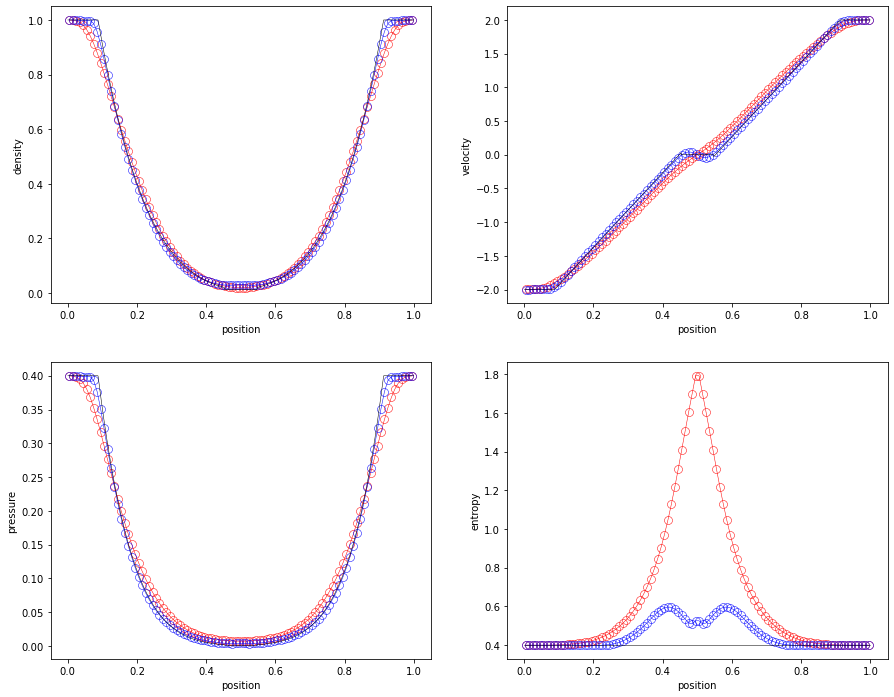

In [17]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.15
    d,v,p = riemann.exact_solution(s,[1,-2,0.4],[1,2,0.4])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(x1,w2[0,:],"bo-",mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(x1,w2[1,:],"bo-",mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(x1,w2[2,:],"bo-",mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,"bo-",mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('toro_test2_high_order.png')

In [18]:
u1=weno(tend=0.012,n=100,cfl=0.8,ic_type="toro test3",bc_type="free",riemann_solver="hllc",time=1,space=1)
u2=weno(tend=0.012,n=100,cfl=0.4,ic_type="toro test3",bc_type="free",riemann_solver="hllc",time=3,space=4)

cell= 100  itermax= 100000
Done  80 0.012103405007493814
cell= 100  itermax= 100000
Done  162 0.012018123884729908


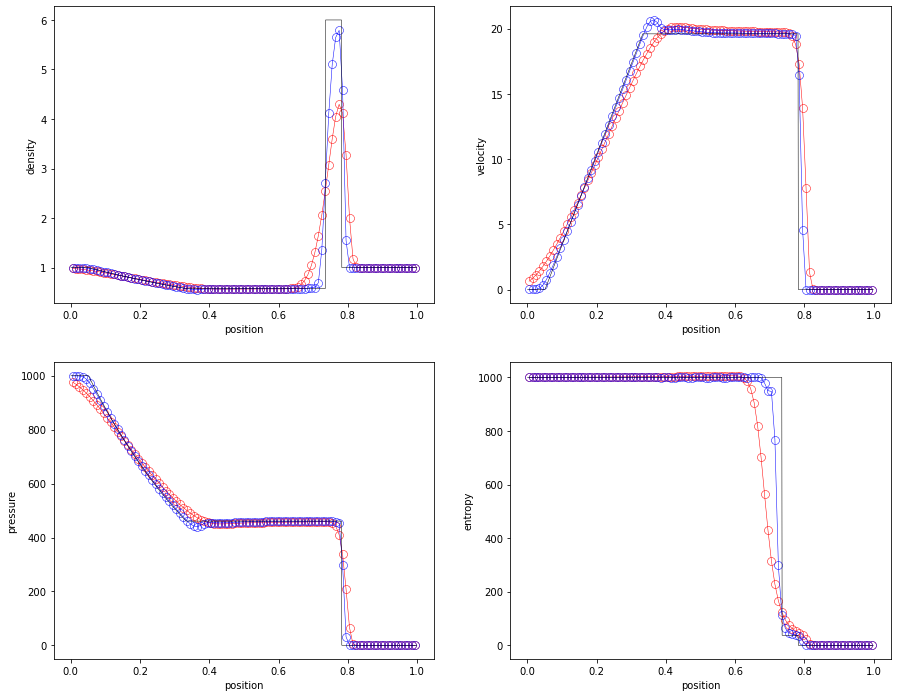

In [19]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.012
    d,v,p = riemann.exact_solution(s,[1,0,1000],[1,0,0.01])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(x1,w2[0,:],"bo-",mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(x1,w2[1,:],"bo-",mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(x1,w2[2,:],"bo-",mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,"bo-",mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('toro_test3_high_order.png')

In [20]:
u1=weno(tend=0.245,n=128,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="exact",time=3,space=4)
u2=weno(tend=0.245,n=128,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="llf"  ,time=3,space=4)
u3=weno(tend=0.245,n=128,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="hll"  ,time=3,space=4)
u4=weno(tend=0.245,n=128,cfl=0.4,ic_type="sod test",bc_type="free",riemann_solver="hllc" ,time=3,space=4)

cell= 128  itermax= 100000
Done  171 0.24514391123968488
cell= 128  itermax= 100000
Done  171 0.2451900618072984
cell= 128  itermax= 100000
Done  171 0.24505815182069418
cell= 128  itermax= 100000
Done  171 0.24510976967256745


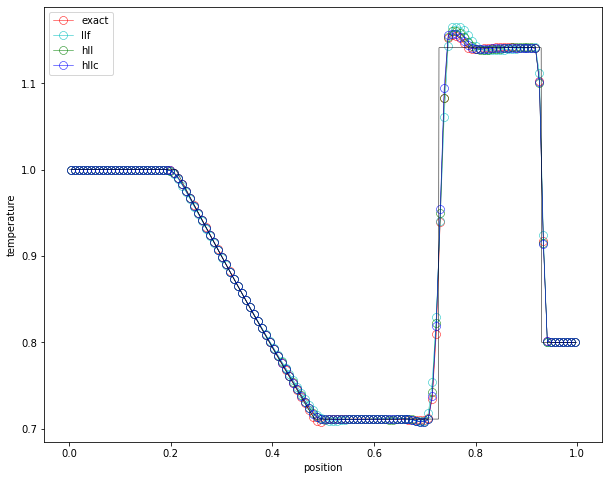

In [21]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])
w3 = cons_to_prim(u3[-1,:,:])
w4 = cons_to_prim(u4[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.245
    d,v,p = riemann.exact_solution(s,[1,0,1],[0.125,0.,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("temperature")
ax1.plot(x1,w1[2,:]/w1[0,:],"ro-",mfc='none',label="exact")
ax1.plot(x1,w2[2,:]/w2[0,:],"co-",mfc='none',label="llf")
ax1.plot(x1,w3[2,:]/w3[0,:],"go-",mfc='none',label="hll")
ax1.plot(x1,w4[2,:]/w4[0,:],"bo-",mfc='none',label="hllc")
ax1.plot(xana,wana[2,:]/wana[0,:],"k")

ax1.legend()

plt.savefig('riemann_comp_high_order.png')

In [28]:
uref=weno(tend=0.178,n=10000,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=3,space=4)

cell= 10000  itermax= 100000
Done  21308 0.178007065548467


In [46]:
gamma=1.4
t0=time.time()
u1=weno(tend=0.178,n=400,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=1,space=1)
t1=time.time()
u2=weno(tend=0.178,n=400,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=2,space=2)
t2=time.time()
u3=weno(tend=0.178,n=400,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=3,space=3)
t3=time.time()
u4=weno(tend=0.178,n=400,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=3,space=4)
t4=time.time()
u5=weno(tend=0.178,n=400,cfl=0.4,ic_type="shu osher",bc_type="free",riemann_solver="hllc",time=4,space=4)
t5=time.time()
tt=t1-t0
print(tt)

cell= 400  itermax= 100000
Done  827 0.17804205811564047
cell= 400  itermax= 100000
Done  840 0.17818563518259317
cell= 400  itermax= 100000
Done  844 0.17806567628949566
cell= 400  itermax= 100000
Done  848 0.1780776498032997
cell= 400  itermax= 100000
Done  848 0.17813139345564594
0.255023717880249


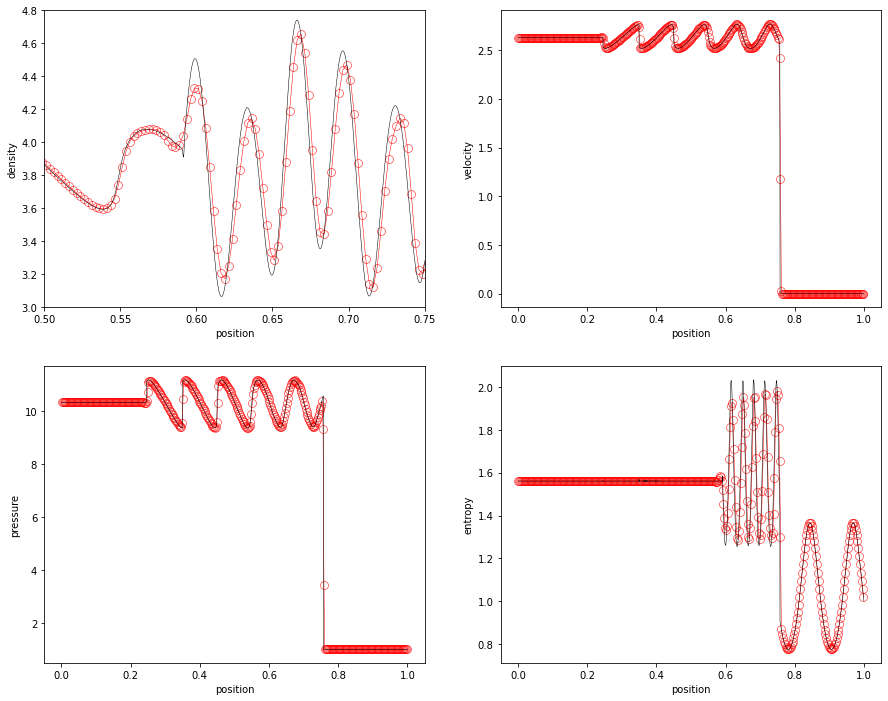

In [47]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])
w3 = cons_to_prim(u3[-1,:,:])
w4 = cons_to_prim(u4[-1,:,:])
w5 = cons_to_prim(u5[-1,:,:])

xref = (np.arange(uref.shape[2])+0.5)/uref.shape[2]
wref = cons_to_prim(uref[-1,:,:])

ax1.set_xlabel("position")
ax1.set_ylabel("density")
ax1.set_xlim([0.5,0.75])
ax1.set_ylim([3,4.8])
ax1.plot(x1,w5[0,:],"ro-",mfc='none')
ax1.plot(xref,wref[0,:],"k-")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w5[1,:],"ro-",mfc='none')
ax2.plot(xref,wref[1,:],"k-")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w5[2,:],"ro-",mfc='none')
ax3.plot(xref,wref[2,:],"k-")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w5[2,:]/w5[0,:]**gamma,"ro-",mfc='none')
ax4.plot(xref,wref[2,:]/wref[0,:]**gamma,"k-")


In [25]:
u1=weno(tend=0.35,n=100,cfl=0.8,ic_type="toro test6",bc_type="free",riemann_solver="llf",time=1,space=1)
u2=weno(tend=0.35,n=100,cfl=0.4,ic_type="toro test6",bc_type="free",riemann_solver="llf",time=3,space=4)

cell= 100  itermax= 100000
Done  1001 0.35004183333270855
cell= 100  itermax= 100000
Done  2002 0.35003887008609


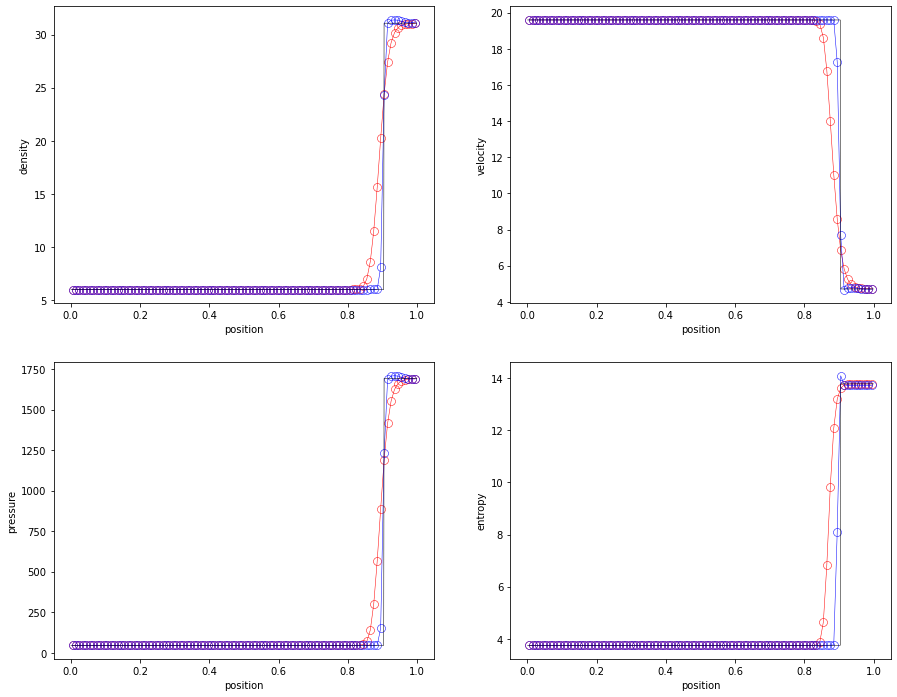

In [26]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.35
    d,v,p = riemann.exact_solution(s,[5.99924,19.5975,46.0950],[31.0799559,4.71607927,1692.45760109])
    wana[:,i]=[d,v,p]
   
ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(x1,w2[0,:],"bo-",mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(x1,w2[1,:],"bo-",mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(x1,w2[2,:],"bo-",mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,"bo-",mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('toro_test3_high_order.png')